In [152]:
using JLD, Mamba
using Pipe
include("gyncycle.jl")

acceptance(mc::Array) = mapslices(mc,[1,2]) do mc
    n = size(mc,1)
    sum([mc[i,:,:] != mc[i+1,:,:] for i in 1:n-1]) / (n-1);
  end |> vec

acceptance(c::AbstractChains) = acceptance(c.value)

escaped(c::AbstractChains) = mapslices(c.value, [1,2]) do c
    sum(c[:,1,:] .< 10^5)
  end |> vec

mergeparms!(aparms, sparms) = (aparms[SAMPLEPARMS]=sparms; aparms)

mergeparms(aparms,sparms) = mergeparms!(copy(aparms), sparms)

function loglikelihood(mc::Array{Float64,3}, data::Matrix)
    mapslices(mc.value, 2) do modelparms
        aparms = mergeparms(parms, modelparms[1:length(SAMPLEPARMS)])
        y0 = modelparms[length(SAMPLEPARMS)+1:end]
        loglikelihood(data, aparms, y0)
    end
end

mergepersons(mcs) = cat(3,map(x->x[1:minimum(map(x->size(x,1), mcs)),:,:],mcs)...);

loglikelihood(mc::AbstractChains, data::Matrix) = loglikelihood(mc.value, data);

function newestjld()
    jlds = filter(x->endswith(x, "jld"), readdir())
    jlds[indmax(map(ctime, jlds))]
end;

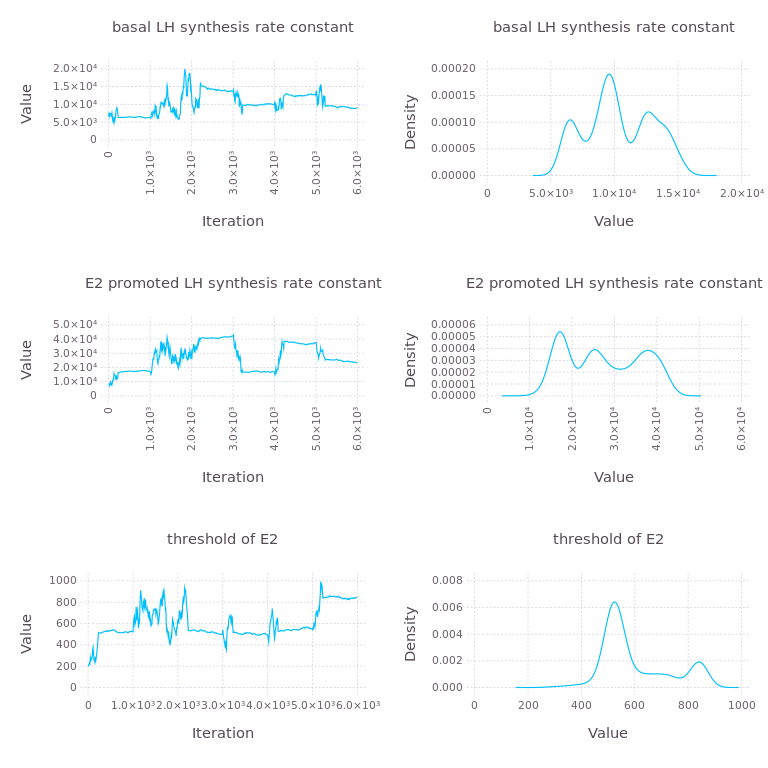

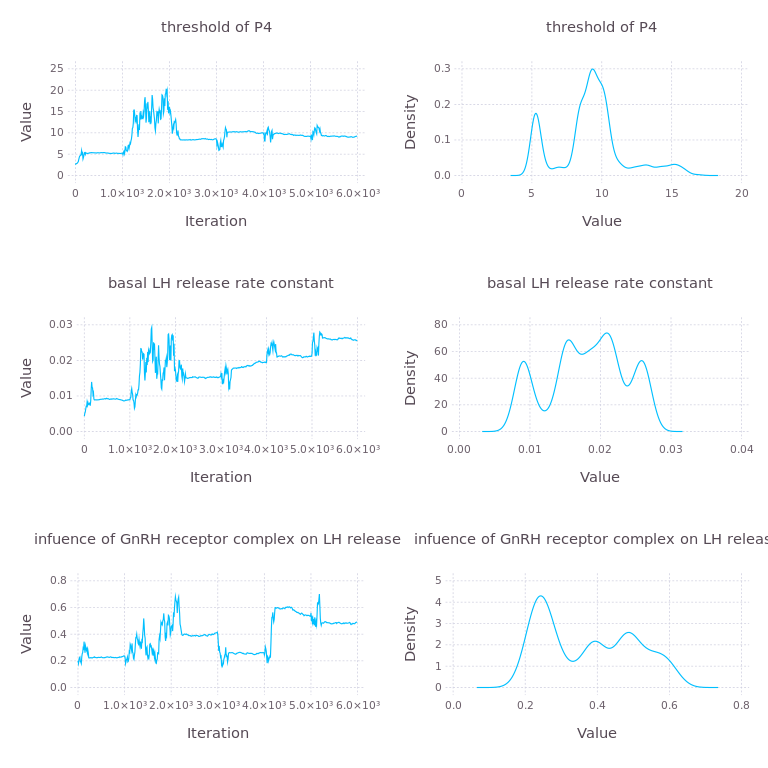

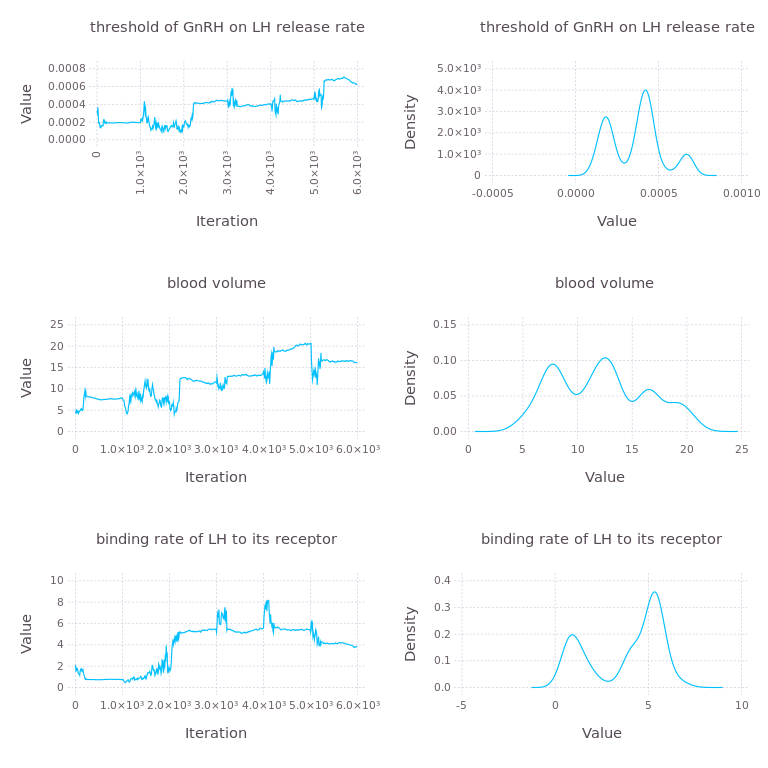

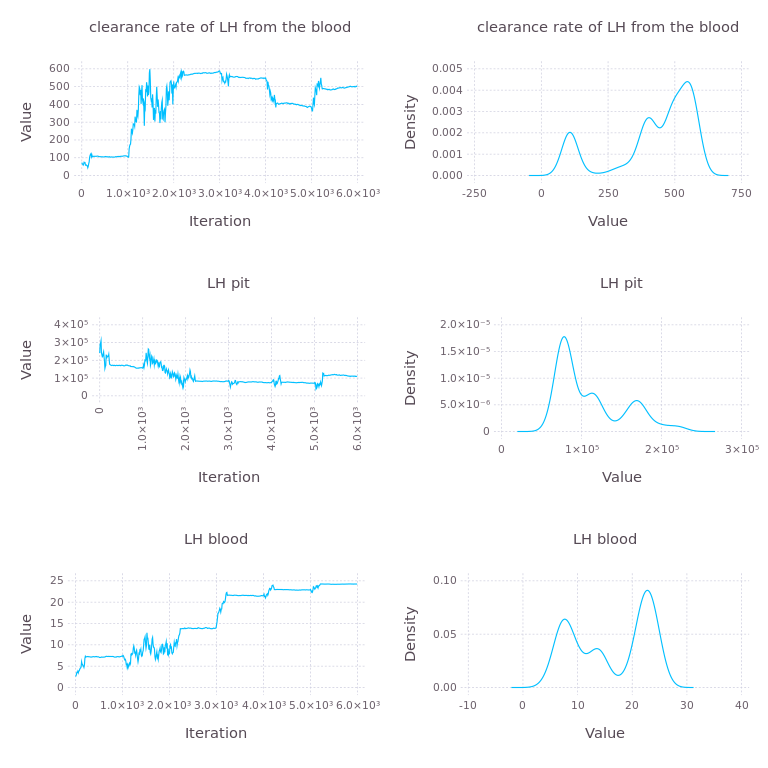

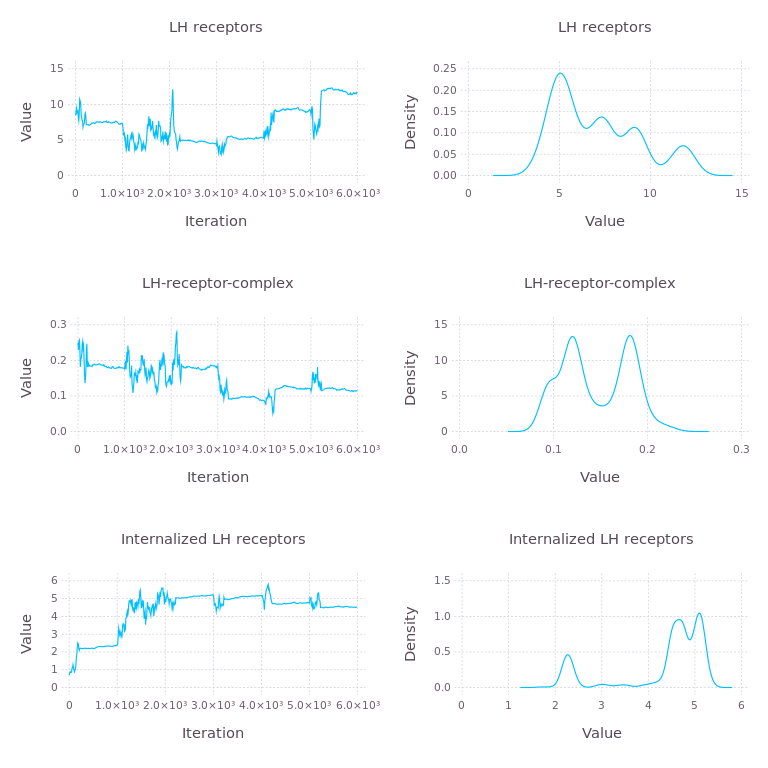

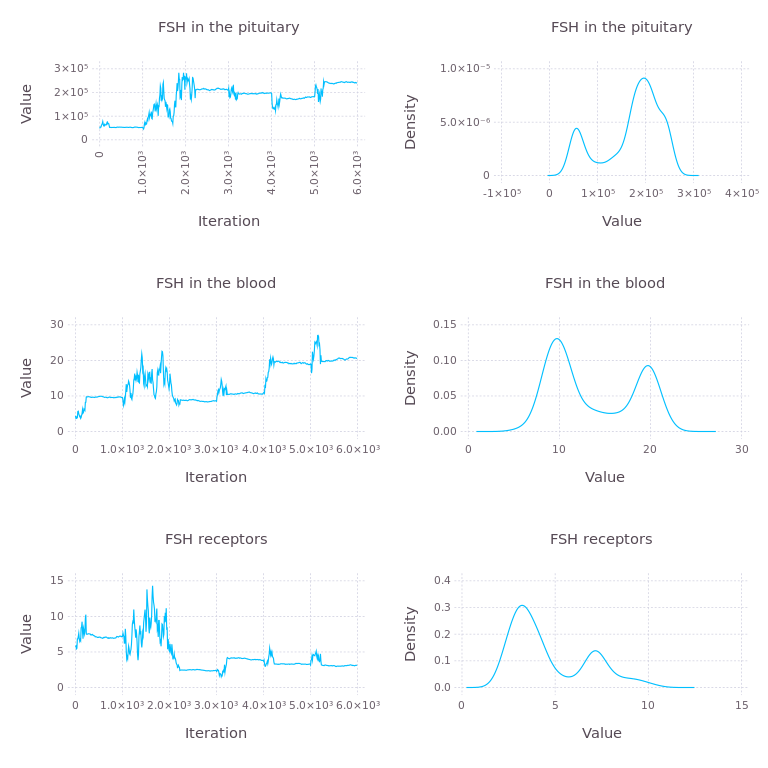

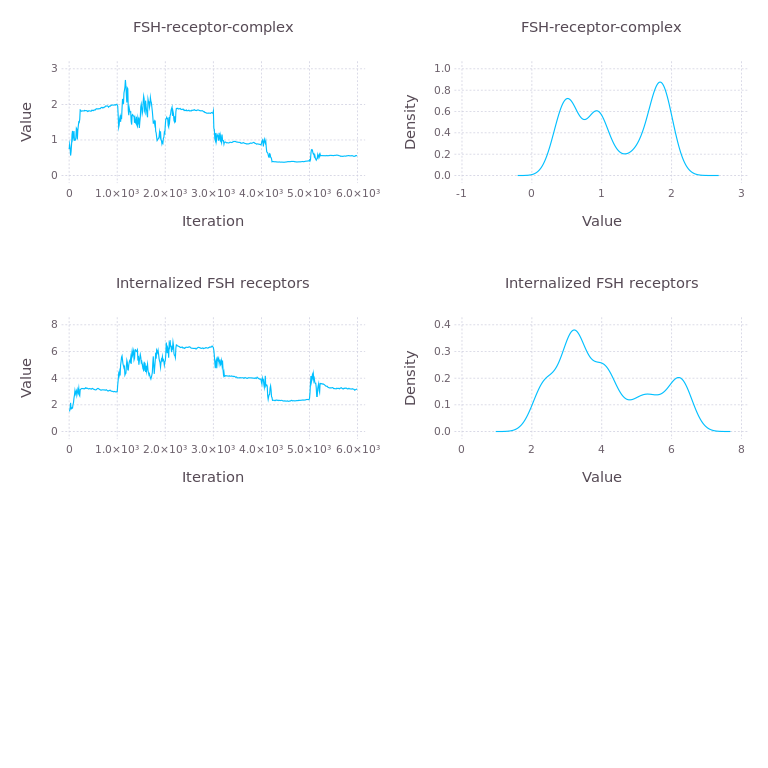

0.012475 seconds (303 allocations: 15.808 MB, 46.01% gc time)
file: 1pers-adaptnone-0.3-10-10-0.05-truncflatprior.jld
size: (6000,115,1)
acc:  [1.0]


In [188]:
file = newestjld()
@time mcs = load(file)["mc"] |> mergepersons
mcs = Chains(mcs, names = vcat(parameternames[SAMPLEPARMS], speciesnames))
println("file: ", file)
println("size: ", size(mcs))
println("acc:  ", map(x->round(x,2),acceptance(mcs)))
draw(plot(mcs[1:10:end,[1:10,83:92],:]), ask=false, fmt=:png)

In [42]:
using Clustering
pmc = mc[:,:,1]

means = mapslices(Base.mean, pmc, 1)
scale = diagm(vec(means))
km = kmeans(inv(scale)*reshape(pmc,size(pmc)[[1,2]])',3)
(km.counts, scale * km.centers)

0.058898 seconds (1.84 k allocations: 34.301 MB, 44.69% gc time)
(1000,115,13)
[0.8368368368368369,0.47647647647647645,0.8208208208208209,0.4134134134134134,0.40540540540540543,0.3133133133133133,0.30430430430430433,0.3163163163163163,0.9379379379379379,0.34634634634634637,0.955955955955956,0.32232232232232233,0.25325325325325326]


LoadError: LoadError: UndefVarError: mc not defined
while loading In[42], in expression starting on line 2